In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import utils
plt.ion()
plt.show()

In [2]:
%load_ext autoreload
import importlib
importlib.reload(utils)

<module 'utils' from 'C:\\workspace\\ml\\modality_tests\\utils.py'>

# Summary

When processing a large number of datasets which can potentially have different data distributions, we are confronted with the following considerations:
- Is the data distribution unimodal and if it is the case, which model best approximates it( uniform distribution, T-distribution, chi-square distribution, cauchy distribution, etc)?
- If the data distribution is multimodal, can we automatically identify the number of modes and provide more granular descriptive statistics?
- How can we estimate the probability density function of a new dataset?


This notebook tackles the following subjects:

- Histograms vs probability density function approximation
- Kernel density estimations
- Choice of optimal bandwidth: Silverman/ Scott/ Grid Search Cross Validation
- Statistical tests for unimodal distributions
- DIP test for unimodality
- Identification of the number of modes of a data distribution based on the kernel density estimation

In [3]:
# Generate data distribution combining 3 normal distributions
data = np.concatenate([
    norm(-10, 3).rvs(200), 
    norm(0, 2).rvs(200),  
    norm(7, 2).rvs(100)
])

# The x values corresponding to the generated distribution
x = np.linspace(data.min(),data.max(), data.shape[0])

true_pdf = (0.4 * norm(-10, 3).pdf(x) + 
            0.4 * norm(0, 2).pdf(x) +
            0.2* norm(7, 2).pdf(x))

# Histograms and PDFs

As explained in this blog post https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html histograms have the drawback of hiding in bins of unsuitable size some of the details of the actual data distribution

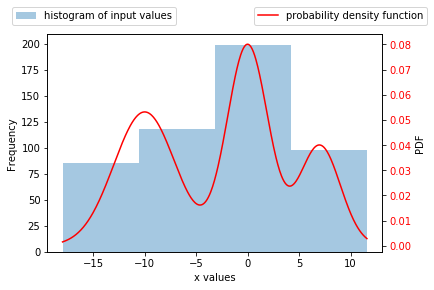

In [18]:
def plotHistogramAndPdf(data, x, pdf):
    ax = plt.gca()
    plt.hist(data, bins = 4, alpha = 0.4, label = 'histogram of input values');
    plt.ylabel('Frequency')
    plt.xlabel('x values')
    ax2 = ax.twinx()
    plt.plot(x, pdf, c = 'red', label = 'probability density function');
    plt.ylabel('PDF')
    [tl.set_color('r') for tl in ax2.get_yticklabels()]
    ax.legend(bbox_to_anchor=(0.4, 1.15))
    ax2.legend(bbox_to_anchor=(1.15,1.15))
    plt.savefig('figures/hist.jpg', bbox_inches='tight')
    
plotHistogramAndPdf(data, x, true_pdf)

# Kernel density estimations

Kernel density estimations are dependent on an arbitrary bandwidth which governs how smooth is the returned approximation. The example below illustrates the effect of various bandwidth values:

In [5]:
def getKernelDensityEstimation(values, x, bandwidth = 0.2, kernel = 'gaussian'):
    model = KernelDensity(kernel = kernel, bandwidth=bandwidth)
    model.fit(values[:, np.newaxis])
    log_density = model.score_samples(x[:, np.newaxis])
    return np.exp(log_density)

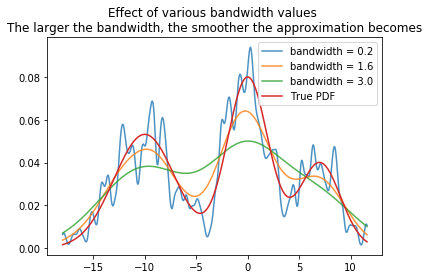

In [6]:
for bandwidth in np.linspace(0.2, 3, 3):
    kde = getKernelDensityEstimation(data, x, bandwidth=bandwidth)
    plt.plot(x, kde, alpha = 0.8, label = f'bandwidth = {round(bandwidth, 2)}')
plt.plot(x, true_pdf, label = 'True PDF')
plt.legend()
plt.title('Effect of various bandwidth values \nThe larger the bandwidth, the smoother the approximation becomes');
plt.savefig('figures/bw.jpg', bbox_inches='tight')

# Methods for selecting the optimal banwidth for the kernel density estimation

In order to identify the optimal bandwidth, there are a few types of approaches:

- Silverman's rule of thumb: assumes Gaussian distribution for the unknown density. It is not the most optimal bandwidth selector but is used either as a very fast reasonably good estimator or as a first estimator in multistage bandwidth selectors. More precise solve-the-equation plug-in rules use estimation of integrated squared density derivative functional to estimate the optimal bandwidth. They demand high computations to solve a non-linear equation using iterative methods. They use ROT as a very first estimate
- Scott's rule of thumb:is optimal for random samples of normally distributed data, in the sense that it minimizes the integrated mean squared error of the density estimate.  

These 2 methods have the advantage of being computationally fast, but they usually give too few bins and that it is likely to underfit the underlying data distribution. Both methods have been implemented in statsmodels package and illustrated below.
- Methods based on cross validation: statsmodels comes with an cv bandwidth parameter. Alternatively, we can implement a grid search cross validation. Unlike the first 2 methods, performing a grid search is likely to be more computationally expensive, especially for larger datasets

In [7]:
from statsmodels.nonparametric.bandwidths import bw_silverman, bw_scott, select_bandwidth

In [8]:
silverman_bandwidth = bw_silverman(data)

# select bandwidth allows to set a different kernel
silverman_bandwidth_gauss = select_bandwidth(data, bw = 'silverman', kernel = 'gauss')

scott_bandwidth = bw_scott(data)

C:\Users\ciort\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [9]:
def bestBandwidth(data, minBandwidth = 0.1, maxBandwidth = 2, nb_bandwidths = 30, cv = 30):
    """
    Run a cross validation grid search to identify the optimal bandwidth for the kernel density
    estimation.
    """
    from sklearn.model_selection import GridSearchCV
    model = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(minBandwidth, maxBandwidth, nb_bandwidths)}, cv=cv) 
    model.fit(data[:, None])
    return model.best_params_['bandwidth']

cv_bandwidth = bestBandwidth(data)

C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [10]:
print(f"Silverman bandwidth = {silverman_bandwidth}")
print(f"Scott bandwidth = {scott_bandwidth}")
print(f"CV bandwidth = {cv_bandwidth}")

Silverman bandwidth = 1.8293406725911592
Scott bandwidth = 2.152524191415597
CV bandwidth = 0.886206896551724


As expected, the first Silverman and Scott return larger bandwidth values which lead to bigger bins and thus the loss of information about the data distribution.  

Statsmodels allows for an automatic search of the optimal bandwidth based on cross validation and a maximum likelihood operator:

In [11]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
stats_models_cv = KDEMultivariate(data, 'c', bw = 'cv_ml').pdf(x)

C:\Users\ciort\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_density.py:161: RuntimeWarning: invalid value encountered in log
  L += func(f_i)


## Plot the different approximations

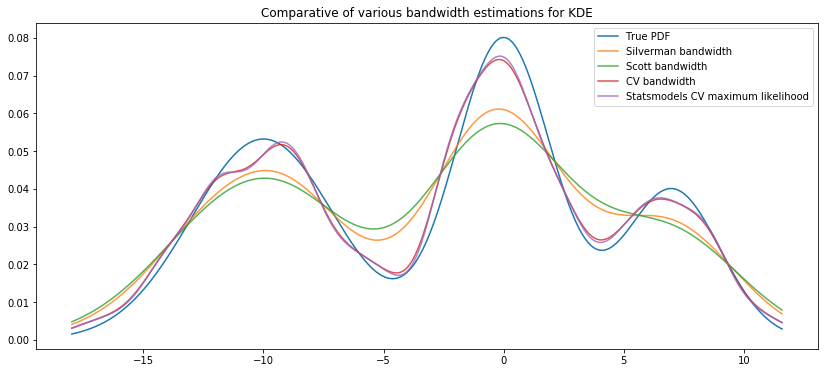

In [12]:
plt.figure(figsize= (14, 6))
plt.plot(x, true_pdf, label = 'True PDF')

kde = getKernelDensityEstimation(data, x, bandwidth=silverman_bandwidth)
plt.plot(x, kde, alpha = 0.8, label = f'Silverman bandwidth')

kde = getKernelDensityEstimation(data, x, bandwidth=scott_bandwidth)
plt.plot(x, kde, alpha = 0.8, label = f'Scott bandwidth')


kde = getKernelDensityEstimation(data, x, bandwidth=cv_bandwidth)
plt.plot(x, kde, alpha = 0.8, label = f'CV bandwidth')


plt.plot(x, stats_models_cv, alpha = 0.8, label = f'Statsmodels CV maximum likelihood')

plt.legend()
plt.title('Comparative of various bandwidth estimations for KDE');
plt.savefig('figures/comp_bw.jpg', bbox_inches='tight')

# Statistical tests for unimodal distributions

There are a number of statistical tests addressing the data modality problem:
- DIP test
- excess mass test
- MAP test
- mode existence test
- runt test
- span test
- saddle test

Unfortunately, not many have been implemented in python open source libraries.

https://en.wikipedia.org/wiki/Multimodal_distribution

## DIP Test

The following python package https://github.com/BenjaminDoran/unidip provides an implementation of the dip test and also a functionality to ecursively extracts peaks of density in the data utilizing the Hartigan Dip-test of Unimodality.

For installation:  
#!pip install unidip

In [13]:
from unidip import UniDip
import unidip.dip as dip

The second value is the dip test p-value which < 0.05 shows that our data is not unimodal.

In [14]:
data = np.msort(data)
print(dip.diptst(data))
intervals = UniDip(data).run()
print(intervals)

(0.03959813034127299, 0.000999000999000999, (210, 392))
[(12, 161), (210, 391)]


When trying the functionality on a gaussian distribution we get one interval and a big p-value.

In [15]:
gaussianData=norm(-10, 3).rvs(200)
gaussianData = np.msort(gaussianData)
print(dip.diptst(gaussianData))

intervals = UniDip(gaussianData).run()
print(intervals)

(0.018270619849269046, 0.955044955044955, (62, 92))
[(0, 199)]


# Identify and plot local maximum values of the KDE 

Once we have an estimation of the kernel density funtction we can determine if the distribution is multimodal and identify the maximum values or peaks corresponding to the modes.  
This can be done by identifying the points where the first derivative changes the sign. The method getInflexion points can return by default all inflexion points ( minima + maxima) or just a selection (typeOfInflexion = 'max'/ 'min').  
The plot below depicts these maximum values which may correspond to multiple modes of the data distribution. The analysis can be continued by setting a threshold based on the height of the peak in order to filter out some less significant values.

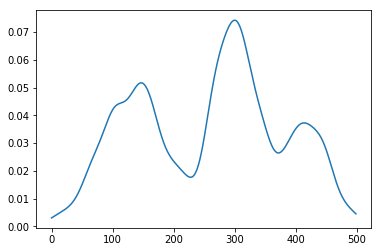

In [16]:
plt.plot(kde)

Mode values [-9.26859422 -0.2028573   6.5520055 ]


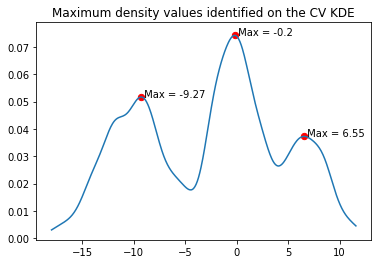

In [17]:
kde = getKernelDensityEstimation(data, x, bandwidth=cv_bandwidth)
idx = utils.getInflexionPoints(kde, typeOfInflexion='max')
plt.plot(x,kde)
ax = plt.gca()
for i in idx:
    plt.scatter(x[i], kde[i], s= 40, c = 'red')

for i in idx:
    ax.annotate(f' Max = {round(x[i], 2)}', (x[i], kde[i]))

plt.title('Maximum density values identified on the CV KDE')
modeValues =np.sort(x[idx])
print(f'Mode values {modeValues}')
plt.savefig('figures/max.jpg', bbox_inches='tight')

We notice that the obtained values correspond to the initial anchors of the generated distribution.

# Resources
- https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
- https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html
- https://en.wikipedia.org/wiki/Multimodal_distribution